In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
# Import our training and testing datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

In [6]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


From the dataframe's info we see that the total records are 891 rows. Out of this 891 rows, columns Age, Cabin and Embarked has certain null values which we will have to clean later on.

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In our test dataset, columns Age, Cabin has some null values

In [12]:
train_df[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Clearly passengers travelling in class 1 had a much higher chances of survival. This is an important feature to train our dataset.

In [18]:
train_df[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Females had a much higher chance of surviving at around 74%, another important feature to train our dataset on.

In [20]:
train_df[["SibSp", "Survived"]].groupby(["SibSp"],as_index=False).mean().sort_values(by="Survived", ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [21]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


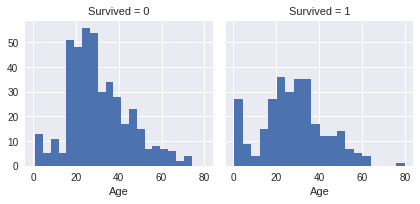

In [24]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.show()

Observations:

Infants (Age <=4) had high survival rate.

Oldest passengers (Age = 80) survived.

Large number of 15-25 year olds did not survive.

Most passengers are in 15-35 age range.

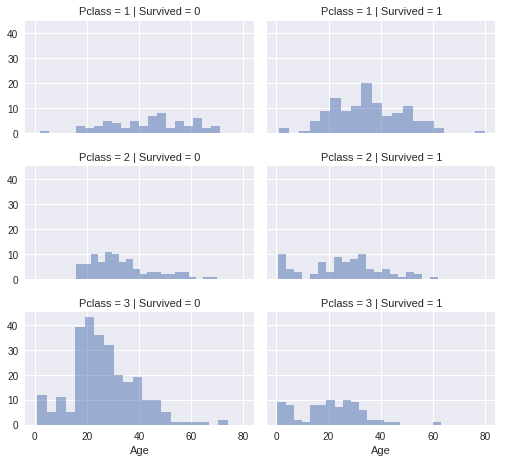

In [25]:
# 
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();
plt.show()

Observations:

Pclass=3 had most passengers, however most did not survive.

Infant passengers in Pclass=2 and Pclass=3 mostly survived.

Most passengers in Pclass=1 survived.

Pclass varies in terms of Age distribution of passengers.

Hence, Pclass seems to be an important feature to consider for training our dataset.

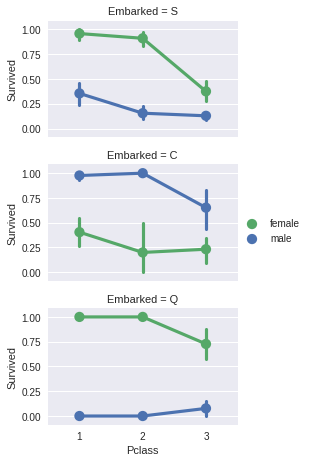

In [26]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()
plt.show()

Observations:

Female passengers had much better survival rate than males.

Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.

Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports.

Ports of embarkation have varying survival rates for Pclass=3 and among male passengers.

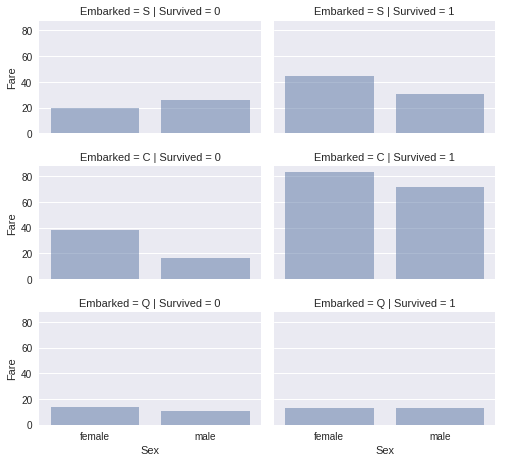

In [27]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()
plt.show()

Higher fare paying passengers had better survival.

Port of embarkation correlates with survival rates.

Hence, Fare amount is another important feature to train our dataset.

In [28]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

In [30]:
'''
We want to analyze if Name feature can be engineered to extract titles and test correlation between titles and survival, 
before dropping Name and PassengerId features.
In the following code we extract Title feature using regular expressions. 
The RegEx pattern (\w+\.) matches the first word which ends with a dot character within Name feature. 
The expand=False flag returns a DataFrame.
'''

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [32]:
#We can replace many titles with a more common name or classify them as Rare.
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [33]:
# We can convert the categorical titles to ordinal.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [34]:
# Now we can safely drop the Name feature from training and testing datasets. 
# We also do not need the PassengerId feature in the training dataset.
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

Now we can convert features which contain strings to numerical values. This is required by most model algorithms. Doing so will also help us in achieving the feature completing goal.

Let us start by converting Sex feature to a new feature called Gender where female=1 and male=0.

In [35]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

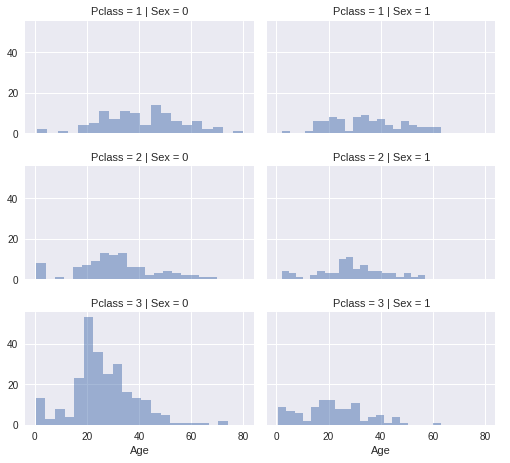

In [36]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()
plt.show()

In [37]:
# Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations.
guess_ages = np.zeros((2,3))
guess_ages

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [38]:
# Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [39]:
# Let us create Age bands and determine correlations with Survived.
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16]",0.550000
1,"(16, 32]",0.337374
2,"(32, 48]",0.412037
3,"(48, 64]",0.434783
4,"(64, 80]",0.090909


In [40]:
# Let us replace Age with ordinals based on these bands.
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16, 32]"
1,1,1,1,2,1,0,71.2833,C,3,"(32, 48]"
2,1,3,1,1,0,0,7.9250,S,2,"(16, 32]"
3,1,1,1,2,1,0,53.1000,S,3,"(32, 48]"
4,0,3,0,2,0,0,8.0500,S,1,"(32, 48]"


In [41]:
# We can now remove the AgeBand feature.
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


In [42]:
# We can create a new feature for FamilySize which combines Parch and SibSp. 
# This will enable us to drop Parch and SibSp from our datasets.
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [43]:
# We can create another feature called IsAlone.
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [44]:
# Let us drop Parch, SibSp, and FamilySize features in favor of IsAlone.
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [45]:
# We can also create an artificial feature combining Pclass and Age.
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [46]:
# Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. 
# We simply fill these with the most common occurance.
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [47]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [48]:
# We can now convert the Embarked feature by creating a new numeric Port feature.
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


In [49]:
# We can now complete the Fare feature for single missing value in test dataset using mode to get the value 
# that occurs most frequently for this feature. We do this in a single line of code.
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [50]:
# We can now create FareBand.
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"[0, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31]",0.454955
3,"(31, 512.329]",0.581081


In [51]:
# Convert the Fare feature to ordinal values based on the FareBand.
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [52]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


Model, predict and solve
----------------------------
Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:
<ul>
<li>Logistic Regression</li>
<li>KNN or k-Nearest Neighbors</li>
<li>Support Vector Machines</li>
<li>Naive Bayes classifier</li>
<li>Decision Tree</li>
<li>Random Forrest</li>
<li>Perceptron</li>
<li>Artificial neural network</li>
<li>RVM or Relevance Vector Machine</li>
</ul>

In [53]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. Reference <a href="https://en.wikipedia.org/wiki/Logistic_regression" target="_blank">Wikipedia</a>.

Note the confidence score generated by the model based on our training dataset.

In [54]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.359999999999999

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

In [55]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201527
5,Title,0.398234
2,Age,0.287164
4,Embarked,0.261762
6,IsAlone,0.129140
3,Fare,-0.085150
7,Age*Class,-0.311199
0,Pclass,-0.749006


<ul>
<li>Sex is highest positivie coefficient, implying as the Sex value increases (male: 0 to female: 1), the probability of Survived=1 increases the most.</li>
<li>Inversely as Pclass increases, probability of Survived=1 decreases the most.</li>
<li>This way Age*Class is a good artificial feature to model as it has second highest negative correlation with Survived.</li>
<li>So is Title as second highest positive correlation.</li>
</ul>

Next we model using Support Vector Machines which are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. Reference <a href="https://en.wikipedia.org/wiki/Support_vector_machine" target="_blank">Wikipedia</a>.

Note that the model generates a confidence score which is higher than Logistics Regression model.

In [56]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.840000000000003

In pattern recognition, the k-Nearest Neighbors algorithm (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. Reference <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm" target="_blank">Wikipedia</a>.

KNN confidence score is better than Logistics Regression but worse than SVM.

In [57]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.739999999999995

In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference <a href="https://en.wikipedia.org/wiki/Naive_Bayes_classifier" target="_blank">Wikipedia</a>.

The model generated confidence score is the lowest among the models evaluated so far.

In [58]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

72.280000000000001

The perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time. Reference <a href="https://en.wikipedia.org/wiki/Perceptron" target="_blank">Wikipedia</a>.

In [59]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

78.0

In [60]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

79.120000000000005

In [61]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

71.939999999999998

This model uses a decision tree as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference <a href="https://en.wikipedia.org/wiki/Decision_tree_learning" target="_blank">Wikipedia</a>.

The model confidence score is the highest among models evaluated so far.

In [62]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.760000000000005

The next model Random Forests is one of the most popular. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators=100) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference <a href="https://en.wikipedia.org/wiki/Random_forest" target="_blank">Wikipedia</a>.

The model confidence score is the highest among models evaluated so far. We decide to use this model's output (Y_pred) for creating our competition submission of results.

In [63]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.760000000000005

Model evaluation
------------------

We can now rank our evaluation of all the models to choose the best one for our problem. While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set.

In [64]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.76
8,Decision Tree,86.76
1,KNN,84.74
0,Support Vector Machines,83.84
2,Logistic Regression,80.36
7,Linear SVC,79.12
5,Perceptron,78.00
4,Naive Bayes,72.28
6,Stochastic Gradient Decent,71.94


In [66]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)